In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from BaseSMLM import generators, localize, utils, psf
from DeepSMLM.models import Ring_Rad1_K5
from SPICE.mcmc import run_langevin_dynamics
from SPICE.generators import SPAD2D_Ring

### Generate some example SPAD data

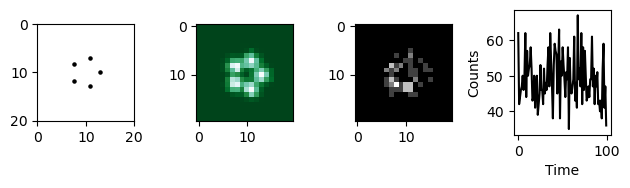

In [3]:
config = {
    "nx": 20,
    "ny": 20,
    "sigma": 0.92,
    "lam0": 1000,
    "nt": 100,
    "particles": 5
}

spad2d = SPAD2D_Ring(config)
counts,probsum,theta_star = spad2d.generate(ring_radius=3,show=True)
csum = np.sum(counts,axis=0)

### Load a default DeepSTORM model, estimate of emitter locations

In [ ]:
cnn_config = {'thresh_cnn':5,'radius':4,'pixel_size_lateral':108.3}
model = Ring_Rad1_K5(cnn_config)
csum = csum[np.newaxis,np.newaxis,:,:] #add batch and channel index for torch
spots,bstar = model.forward(csum)

### Extract $Z$ from CNN output

In [35]:
theta = spots.values[:,:2]
theta_ = np.ones_like(theta)
theta_[:,0] *= 0.92; theta[:,1] *= 1000
theta_init = np.concatenate([theta,theta_],axis=1).T #initialize sigma and N0

### Run Langevin dynamics

In [36]:
adu = np.squeeze(adu)
lr = torch.tensor(np.array([1e-9,1e-9,0.0,0.0])) #only update x,y
theta_init = thetagt #just use the true parameters for now (need to train a better CNN)
ntheta,nspots = thetagt.shape
#theta_init[0,:] += np.random.normal(0,1,size=(nspots,))
#theta_init[1,:] += np.random.normal(0,1,size=(nspots,))
theta,loglikes = run_langevin_dynamics(adu,initial_params=theta_init,lr=lr,
                                       num_samples=1000,warmup_steps=100,print_every=100)
print(f'Average log likelihood: {np.mean(loglikes)}')

MCMC step 0
MCMC step 100
MCMC step 200
MCMC step 300
MCMC step 400
MCMC step 500
MCMC step 600
MCMC step 700
MCMC step 800
MCMC step 900
MCMC step 1000
Average log likelihood: 2989.735402059247


NameError: name 'loglikes' is not defined

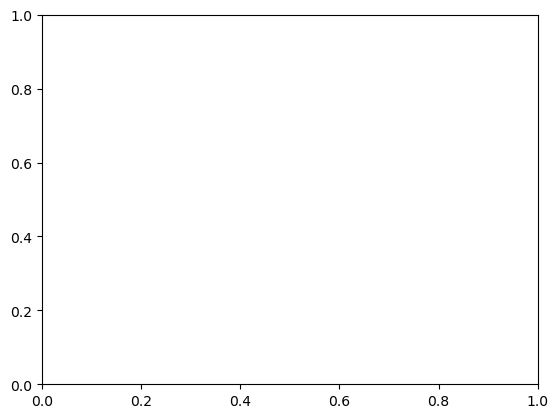

In [32]:
fig,ax=plt.subplots()
ax.plot(loglikes,color='black')
ax.set_xlabel('Iteration')
ax.set_ylabel('NLL')
plt.show()

NameError: name 'loglikes' is not defined

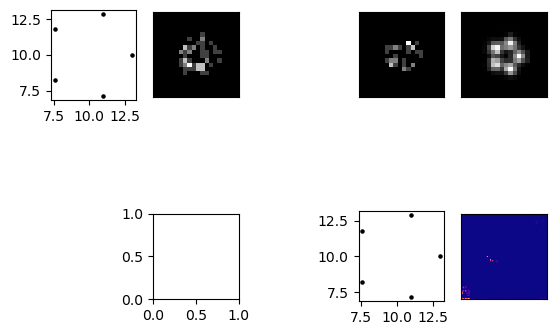

In [31]:
fig,ax=plt.subplots(2,5)
ax[0,0].scatter(theta_star[1,:],theta_star[0,:],color='black',s=5)
ax[0,2].set_axis_off(); ax[1,2].set_axis_off()
ax[0,1].imshow(counts[0],cmap='gray')
ax[0,1].set_xticks([]); ax[0,3].set_xticks([])
ax[0,1].set_yticks([]); ax[0,3].set_yticks([])
ax[0,3].imshow(counts[-1],cmap='gray')
ax[0,4].imshow(np.squeeze(csum),cmap='gray')
ax[0,4].set_xticks([])
ax[0,4].set_yticks([])
ax[1,4].imshow(bstar,cmap='plasma')
ax[1,4].set_xticks([])
ax[1,4].set_yticks([])
ax[1,0].set_axis_off()
ax[1,3].scatter(theta_star[1,:],theta_star[0,:],color='black',s=5)
for ax_ in ax.ravel():
    ax_.set_aspect('equal')
ax[1,2].plot(loglikes,color='black')
ax[1,2].set_xlabel('Iteration')
ax[1,2].set_ylabel('NLL')
#plt.tight_layout()

In [ ]:
def scatter_samples(theta,adu,thetagt=None):
    fig,ax=plt.subplots(1,2)
    nsamples,nparams,nspots = theta.shape
    for n in range(nspots):
        this_theta = theta[:,:,n]
        ax[0].scatter(this_theta[:,1],this_theta[:,0],color='red',marker='x',s=5)
        avgx = np.mean(this_theta[:,1]); avgy = np.mean(this_theta[:,0])
        ax[1].scatter(this_theta[:,1]-avgx,this_theta[:,0]-avgy,marker='x',s=5,alpha=0.2)
    if thetagt is not None:
        ax[0].scatter(thetagt[:,1],thetagt[:,0],color='blue',marker='x',s=5)
    ax[0].imshow(adu,cmap='gray')
    ax[0].set_aspect('equal'); ax[1].set_aspect('equal')
    plt.tight_layout()
    plt.show()